In [54]:
import tensorflow as tf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import losses_utils
import numpy as np
import pickle as pkl
from sklearn.metrics import mean_absolute_error

1  Pobieranie danych

In [55]:
# tf.keras.utils.get_file("bike_sharing_dataset.zip", "https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip", cache_dir=".", extract=True)

In [56]:
df=pd.read_csv('datasets/hour.csv',parse_dates={'datetime': ['dteday','hr']},date_format='%Y-%m-%d %H',index_col='datetime')
print((df.index.min(), df.index.max()))
print((365+366)*24-len(df))

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-31 23:00:00'))
165


In [65]:
df.notna().sum()
df[['casual','registered','cnt','weathersit']].describe()

df.casual/=1e3
df.registered/=1e3
df.cnt/=1e3
df.weathersit/=4

<Axes: xlabel='datetime'>

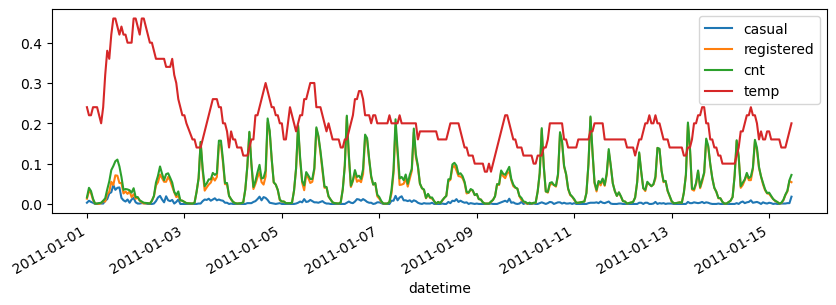

In [58]:
df_2weeks= df[:24*7*2]
df_2weeks[['casual','registered','cnt','temp']].plot(figsize=(10,3))

<Axes: xlabel='datetime'>

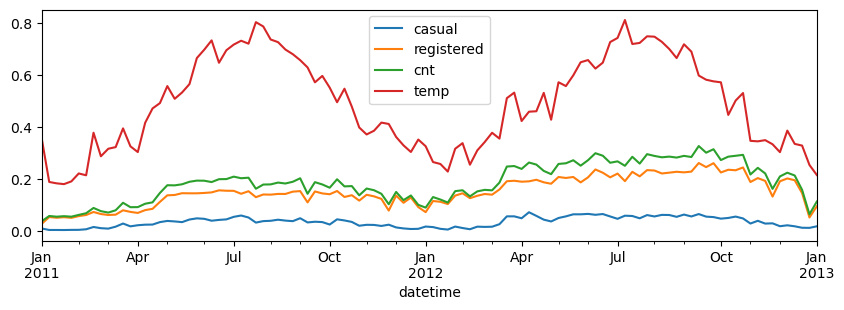

In [59]:
df_daily=df.resample('W').mean()
df_daily[['casual','registered','cnt','temp']].plot(figsize=(10,3))

3  Wskaźniki bazowe

In [67]:
mae_daily = df['cnt'].diff(24).abs().mean() * 1e3
mae_weekly = df['cnt'].diff(24 * 7).abs().mean() * 1e3

print((mae_daily, mae_weekly))
with open('mae_baseline.pkl', 'wb') as f:
    pkl.dump((mae_daily, mae_weekly), f)

(65.07908692644685, 64.74395489421066)


4  Predykcja przy pomocy sieci gęstej

In [68]:
cnt_train=df['cnt']['2011-01-01 00:00':'2012-06-30 23:00']
cnt_valid=df['cnt']['2012-07-01 00:00':]

seq_len=24

train_ds=tf.keras.utils.timeseries_dataset_from_array(cnt_train.to_numpy(),targets=cnt_train[seq_len:],sequence_length=seq_len,batch_size=32,shuffle=True,seed=42)

valid_ds=tf.keras.utils.timeseries_dataset_from_array(cnt_valid.to_numpy(),targets=cnt_valid[seq_len:],sequence_length=seq_len,batch_size=32)

model=tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[seq_len])])

loss = tf.keras.losses.Huber()

model.compile(optimizer="sgd", loss= loss, metrics='mae')
history = model.fit(train_ds, validation_data=valid_ds, epochs=20)

model.save('model_linear.h5')

preds = model.predict(valid_ds)
true_values = np.concatenate([y.numpy() for x, y in valid_ds])
mae_linear = mean_absolute_error(true_values, preds)

print(mae_linear)
with open('mae_linear.pkl', 'wb') as f:
    pkl.dump((mae_linear,), f)

Epoch 1/20
406/406 [==============================] - 2s 4ms/step - loss: 0.0283 - mae: 0.1880 - val_loss: 0.0365 - val_mae: 0.2230
Epoch 2/20
406/406 [==============================] - 1s 2ms/step - loss: 0.0134 - mae: 0.1311 - val_loss: 0.0208 - val_mae: 0.1618
Epoch 3/20
406/406 [==============================] - 1s 2ms/step - loss: 0.0083 - mae: 0.1006 - val_loss: 0.0143 - val_mae: 0.1286
Epoch 4/20
406/406 [==============================] - 1s 2ms/step - loss: 0.0061 - mae: 0.0833 - val_loss: 0.0111 - val_mae: 0.1111
Epoch 5/20
406/406 [==============================] - 1s 2ms/step - loss: 0.0050 - mae: 0.0738 - val_loss: 0.0094 - val_mae: 0.1016
Epoch 6/20
406/406 [==============================] - 1s 2ms/step - loss: 0.0044 - mae: 0.0683 - val_loss: 0.0085 - val_mae: 0.0958
Epoch 7/20
406/406 [==============================] - 1s 2ms/step - loss: 0.0040 - mae: 0.0649 - val_loss: 0.0078 - val_mae: 0.0921
Epoch 8/20
406/406 [==============================] - 1s 2ms/step - loss: 0.

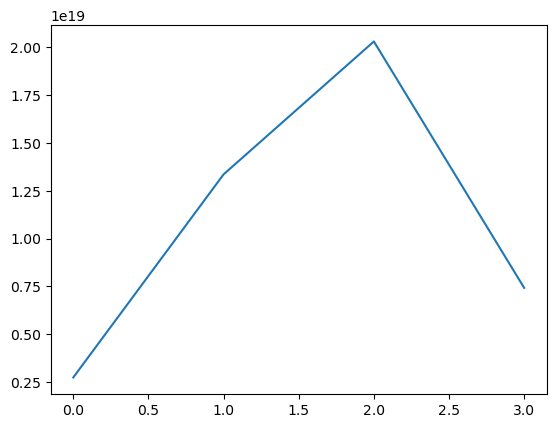

7.415222566522482e+18


5  Prosta sieć rekurencyjna

In [69]:
model=tf.keras.Sequential([tf.keras.layers.SimpleRNN(1, input_shape=[None,1])])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
loss = tf.keras.losses.Huber()

model.compile(optimizer=optimizer, loss= loss, metrics='mae')
history = model.fit(train_ds, validation_data=valid_ds, epochs=20)

model.save("model_rnn1.h5")

preds = model.predict(valid_ds)
true_values = np.concatenate([y.numpy() for x, y in valid_ds])
mae_rnn = mean_absolute_error(true_values, preds)

print(mae_rnn)
with open('mae_rnn1.pkl', 'wb') as f:
    pkl.dump((mae_rnn,), f)

model_rnn32 = tf.keras.Sequential([tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),tf.keras.layers.Dense(1)])

model_rnn32.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])

history = model_rnn32.fit(train_ds, validation_data=valid_ds, epochs=20)

model_rnn32.save('model_rnn32.h5')

preds = model_rnn32.predict(valid_ds)
true_values = np.concatenate([y.numpy() for x, y in valid_ds])
mae_rnn32 = mean_absolute_error(true_values, preds)

print(mae_rnn32)
with open('mae_rnn32.pkl', 'wb') as f:
    pkl.dump((mae_rnn32,), f)

Epoch 1/20
406/406 [==============================] - 3s 5ms/step - loss: 0.0096 - mae: 0.0768 - val_loss: 0.0060 - val_mae: 0.0717
Epoch 2/20
406/406 [==============================] - 2s 4ms/step - loss: 0.0029 - mae: 0.0506 - val_loss: 0.0058 - val_mae: 0.0716
Epoch 3/20
406/406 [==============================] - 1s 3ms/step - loss: 0.0029 - mae: 0.0505 - val_loss: 0.0061 - val_mae: 0.0718
Epoch 4/20
406/406 [==============================] - 1s 3ms/step - loss: 0.0029 - mae: 0.0505 - val_loss: 0.0060 - val_mae: 0.0712
Epoch 5/20
406/406 [==============================] - 1s 3ms/step - loss: 0.0029 - mae: 0.0507 - val_loss: 0.0060 - val_mae: 0.0713
Epoch 6/20
406/406 [==============================] - 1s 3ms/step - loss: 0.0029 - mae: 0.0506 - val_loss: 0.0059 - val_mae: 0.0712
Epoch 7/20
406/406 [==============================] - 1s 3ms/step - loss: 0.0029 - mae: 0.0508 - val_loss: 0.0058 - val_mae: 0.0720
Epoch 8/20
406/406 [==============================] - 1s 3ms/step - loss: 0.

In [44]:
model_rnn_deep = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

model_rnn_deep.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])

history = model_rnn_deep.fit(train_ds, validation_data=valid_ds, epochs=20)

model_rnn_deep.save('model_rnn_deep.h5')

preds = model_rnn_deep.predict(valid_ds)
true_values = np.concatenate([y.numpy() for x, y in valid_ds])
mae_rnn_deep = mean_absolute_error(true_values, preds)

print(mae_rnn_deep)
with open('mae_rnn_deep.pkl', 'wb') as f:
    pkl.dump((mae_rnn_deep,), f)

Epoch 1/20
405/405 [==============================] - 10s 20ms/step - loss: 168296284160.0000 - mae: 168296284160.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 2/20
405/405 [==============================] - 9s 22ms/step - loss: 168296366080.0000 - mae: 168296366080.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 3/20
405/405 [==============================] - 9s 22ms/step - loss: 168296333312.0000 - mae: 168296333312.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 4/20
405/405 [==============================] - 9s 21ms/step - loss: 168296448000.0000 - mae: 168296448000.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 5/20
405/405 [==============================] - 9s 22ms/step - loss: 168296300544.0000 - mae: 168296300544.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 6/20
405/405 [==============================] - 8s 20ms/step - loss: 168296382464.0000 - mae: 168296382464.0

In [45]:
features = df[['cnt', 'weathersit', 'atemp', 'workingday']]
train_mv = features['2011-01-01 00:00':'2012-06-30 23:00']
valid_mv = features['2012-07-01 00:00':]

seq_len = 24
train_ds_mv = tf.keras.utils.timeseries_dataset_from_array(
    train_mv.to_numpy(),
    targets=train_mv['cnt'][seq_len:],
    sequence_length=seq_len,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds_mv = tf.keras.utils.timeseries_dataset_from_array(
    valid_mv.to_numpy(),
    targets=valid_mv['cnt'][seq_len:],
    sequence_length=seq_len,
    batch_size=32
)

model_rnn_mv = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)
])

model_rnn_mv.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

history = model_rnn_mv.fit(train_ds_mv, validation_data=valid_ds_mv, epochs=20)

model_rnn_mv.save('model_rnn_mv.h5')

preds_mv = model_rnn_mv.predict(valid_ds_mv)
true_values_mv = np.concatenate([y.numpy() for x, y in valid_ds_mv])
mae_rnn_mv = mean_absolute_error(true_values_mv, preds_mv)

with open('mae_rnn_mv.pkl', 'wb') as f:
    pkl.dump((mae_rnn_mv,), f)

Epoch 1/20
405/405 [==============================] - 5s 8ms/step - loss: 168296300544.0000 - mae: 168296300544.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 2/20
405/405 [==============================] - 4s 9ms/step - loss: 168296333312.0000 - mae: 168296333312.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 3/20
405/405 [==============================] - 4s 9ms/step - loss: 168296398848.0000 - mae: 168296398848.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 4/20
405/405 [==============================] - 3s 8ms/step - loss: 168296366080.0000 - mae: 168296366080.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 5/20
405/405 [==============================] - 3s 8ms/step - loss: 168296333312.0000 - mae: 168296333312.0000 - val_loss: 254221139968.0000 - val_mae: 254221139968.0000
Epoch 6/20
405/405 [==============================] - 3s 8ms/step - loss: 168296464384.0000 - mae: 168296464384.0000 - v